# 10k Sentiment Analysis Project:

In [1]:
import os
import re
import time
import pandas as pd
import pprint
from tqdm import tqdm
# from pandas import json_normalize
# from datetime import date
# from dateutil.relativedelta import relativedelta
# from dotenv import load_dotenv
# load_dotenv()
# import json
# import urllib.request
# import xml.etree.ElementTree as ET
# from collections import Counter

# Import ML libraries:
# import numpy as np
# from nltk import ngrams
# from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# analyzer = SentimentIntensityAnalyzer()
# nltk.download('vader_lexicon')       # Uncomment this to download the latest package when you run for the first time

# Import plotting libraries:
# import panel as pn
# import holoviews as hv
# import hvplot.pandas
# from holoviews import opts

In [2]:
cik_lookup = {
    'INTC': '0000050863'}#,
#     'GTLS': '0000892553'}

In [4]:
# Project Helper Functions

import matplotlib.pyplot as plt
import requests
from ratelimit import limits, sleep_and_retry


class SecAPI(object):
    SEC_CALL_LIMIT = {'calls': 10, 'seconds': 1}

    @staticmethod
    @sleep_and_retry
    # Dividing the call limit by half to avoid coming close to the limit
    @limits(calls=SEC_CALL_LIMIT['calls'] / 2, period=SEC_CALL_LIMIT['seconds'])
    def _call_sec(url):
        return requests.get(url)

    def get(self, url):
        return self._call_sec(url).text


def print_ten_k_data(ten_k_data, fields, field_length_limit=50):
    indentation = '  '

    print('[')
    for ten_k in ten_k_data:
        print_statement = '{}{{'.format(indentation)
        for field in fields:
            value = str(ten_k[field])

            # Show return lines in output
            if isinstance(value, str):
                value_str = '\'{}\''.format(value.replace('\n', '\\n'))
            else:
                value_str = str(value)

            # Cut off the string if it gets too long
            if len(value_str) > field_length_limit:
                value_str = value_str[:field_length_limit] + '...'

            print_statement += '\n{}{}: {}'.format(indentation * 2, field, value_str)

        print_statement += '},'
        print(print_statement)
    print(']')


def plot_similarities(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(10, 7))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend()
        plt.xticks(rotation=90)

    plt.show()

In [5]:
sec_api = SecAPI()
from bs4 import BeautifulSoup


def get_sec_data(cik, doc_type, start=0, count=60):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('utf-8'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)]
    return entries

example_ticker = 'INTC'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')
    
pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/50863/000005086321000010/0000050863-21-000010-index.htm',
  '10-K',
  '2021-01-22'),
 ('https://www.sec.gov/Archives/edgar/data/50863/000005086320000011/0000050863-20-000011-index.htm',
  '10-K',
  '2020-01-24'),
 ('https://www.sec.gov/Archives/edgar/data/50863/000005086319000007/0000050863-19-000007-index.htm',
  '10-K',
  '2019-02-01'),
 ('https://www.sec.gov/Archives/edgar/data/50863/000005086318000007/0000050863-18-000007-index.htm',
  '10-K',
  '2018-02-16'),
 ('https://www.sec.gov/Archives/edgar/data/50863/000005086317000012/0000050863-17-000012-index.htm',
  '10-K',
  '2017-02-17')]


In [6]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)
            
print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<title>SEC.gov | Request Rate Threshold Exceeded</title>
<style>
html {height: 100%}
body {height: 100%; margin:0; padding:0;}
#header {background-color:#003968; color:#fff; padding:15px 20px 10px 20px;font-family:Arial, Helvetica, sans-serif; font-size:20px; border-bottom:solid 5px #000;}
#footer {background-color:#003968; color:#fff; padding:15px 20px;font-family:Arial, Helvetica, sans-serif; font-size:20px;}
#content {max-width:650px;margin:60px auto; padding:0 20px 100px 20px; background-image:url(seal_bw.png);background-repeat:no-repeat;background-position:50% 100%;}
h1 {font-family:Georgia, Times, serif; font-size:20px;}
h2 {text-align:center; font-family:Georgia, Times, serif; font-size:20px; width:100%; border-bottom:sol

In [10]:
# import re


def get_documents(text):
    extracted_docs = []
    
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')   
    
    doc_start_is = [x.end() for x in      doc_start_pattern.finditer(text)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(text)]
    
    for doc_start_i, doc_end_i in zip(doc_start_is, doc_end_is):
            extracted_docs.append(text[doc_start_i:doc_end_i])
    
    return extracted_docs


filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Filings'.format(ticker), unit='filing'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)
        
print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from GTLS Fillings: 100%|███████████████████████████████████████| 23/23 [00:05<00:00,  3.88filling/s]

Document 0 Filed on 2021-01-22:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>intc-20201226.htm
<DESCRIPTION>10-K
<TEXT>
<XBRL>
<?xml version="1.0" ?><!--XBRL Document Created with Wdesk from Workiva--><!--Copyright 2021 Workiva--><!--r:ed8a096...

Document 1 Filed on 2021-01-22:

<TYPE>EX-21.1
<SEQUENCE>2
<FILENAME>a12262020q4-ex211.htm
<DESCRIPTION>EX-21.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd"><html><head...

Document 2 Filed on 2021-01-22:

<TYPE>EX-23.1
<SEQUENCE>3
<FILENAME>a12262020q4-ex231.htm
<DESCRIPTION>EX-23.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd"><html><head...


In [11]:
def get_document_type(doc):
    
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    
    doc_type = type_pattern.findall(doc)[0][len('<TYPE>'):] 
    
    return doc_type.lower()

In [12]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})
                
print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0000050863'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>intc-2020122...
    file_date: '2021-01-22'},
  {
    cik: '0000050863'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>a12282019q4-...
    file_date: '2020-01-24'},
  {
    cik: '0000050863'
    file: '\n<TYPE>10-K\n<SEQUENCE>2\n<FILENAME>a12282019q41...
    file_date: '2020-01-24'},
  {
    cik: '0000050863'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>a12292018q4-...
    file_date: '2019-02-01'},
  {
    cik: '0000050863'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>a12302017q4-...
    file_date: '2018-02-16'},
]


In [13]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

In [14]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])
print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning GTLS 10-Ks: 100%|███████████████████████████████████████████████████████████| 19/19 [04:33<00:00, 14.38s/10-K]


[
  {
    file_clean: '\n10-k\n1\nintc-20201226.htm\n10-k\n\n\n\nintc-20...},
  {
    file_clean: '\n10-k\n1\na12282019q4-10kdocument.htm\n10-k\n\n\...},
  {
    file_clean: '\n10-k\n2\na12282019q410kdocumentcourte.pdf\n10-k...},
  {
    file_clean: '\n10-k\n1\na12292018q4-10kdocument.htm\n10-k\n\n\...},
  {
    file_clean: '\n10-k\n1\na12302017q4-10kdocument.htm\n10-k\n\n\...},
]


# Lemmatize Words

In [15]:
# from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):

    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    
    return lemmatized_words


word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))
        
print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize GTLS 10-Ks: 100%|██████████████████████████████████████████████████████████| 19/19 [00:35<00:00,  1.89s/10-K]


[
  {
    file_lemma: '['10', 'k', '1', 'intc', '20201226', 'htm', '10',...},
  {
    file_lemma: '['10', 'k', '1', 'a12282019q4', '10kdocument', 'h...},
  {
    file_lemma: '['10', 'k', '2', 'a12282019q410kdocumentcourte', ...},
  {
    file_lemma: '['10', 'k', '1', 'a12292018q4', '10kdocument', 'h...},
  {
    file_lemma: '['10', 'k', '1', 'a12302017q4', '10kdocument', 'h...},
]


# Remove Stopwords

In [16]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]
        
print('Stop Words Removed')

Remove Stop Words for GTLS 10-Ks: 100%|██████████████████████████████████████████████| 19/19 [00:12<00:00,  1.5110-K/s]

Stop Words Removed


In [17]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv('LoughranMcDonald_MasterDictionary_2018.csv')

# Lowercase the columns for ease of use
sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')


sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


In [18]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):

    vec = CountVectorizer(vocabulary=sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names()
    bag_of_words = np.zeros([len(docs), len(words_list)])
    
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]
    return bag_of_words.astype(int)

sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}
    
print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[1 0 0 ... 0 1 0]\n [1 0 0 ... 0 0 0]\n [0 0 0 ....
    positive: '[[17  0  0 ...  0  0  0]\n [13  0  0 ...  0  1  0...
    uncertainty: '[[ 0  0  0 ...  8  0 11]\n [ 0  0  0 ...  6  0  9...
    litigious: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    constraining: '[[0 8 0 ... 0 4 0]\n [0 8 0 ... 0 3 0]\n [0 0 0 ....
    interesting: '[[1 1 0 ... 0 0 0]\n [2 0 0 ... 0 0 0]\n [0 0 0 ....},
]


# Jaccard Similarity

ValueError: x and y must have same first dimension, but have shapes (24,) and (1,)

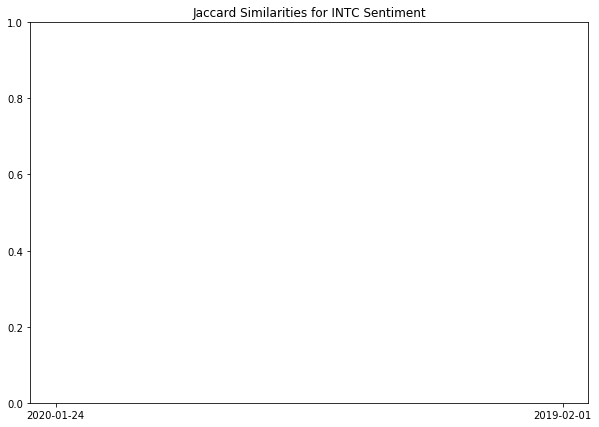

In [19]:
from sklearn.metrics import jaccard_score


def get_jaccard_similarity(bag_of_words_matrix):
    
    jaccard_similarities = []
    bag_of_words_matrix = np.array(bag_of_words_matrix, dtype=bool)
    
    for i in range(len(bag_of_words_matrix)-1):
            u = bag_of_words_matrix[i]
            v = bag_of_words_matrix[i+1]
              
    jaccard_similarities.append(jaccard_score(u,v))    
    
    return jaccard_similarities

# Get dates for the universe
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}
jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}
plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    
    cosine_similarities = []
    
    for i in range(len(tfidf_matrix)-1):
        
        cosine_similarities.append(cosine_similarity(tfidf_matrix[i].reshape(1, -1),tfidf_matrix[i+1].reshape(1, -1))[0,0])
    
    return cosine_similarities

cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}
project_helper.plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
sentiments)

NameError: name 'sentiment_tfidf_ten_ks' is not defined